# Extended Handwriting Classification with a Convolutional Neural Network
A project by Aussie Frost (see README.md for more info).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

random_seed = 11
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

/Users/austinfroste/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/austinfroste/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/austinfroste/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/austinfroste/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Length of train data loader: 390 batches of 256
Length of validation data loader: 98 batches of 256
Length of test data loader: 82 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

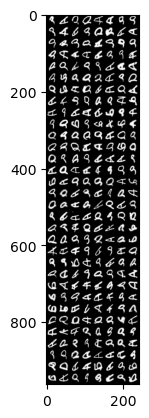

In [3]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
# source: https://madewithml.com/courses/foundations/convolutional-neural-networks/
# has some useful info on CNN implementation

# design CNN model
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        
        # input_size: num of color channels
        # output_size: num of classes
        
        super(ConvModel, self).__init__()
        
        self.conv1 = nn.Conv2d(input_size, 32, kernel_size=7, stride=1, padding=1) # layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1) # layer 2
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, output_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4) # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [5]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    
    # implement one epoch of training
    model.train()
    
    train_loss = 0
    train_acc = 0
    
    for X_train, y_train in train_loader:
        
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # forward
        optimizer.zero_grad()
        y_pred = model(X_train)
        
        # compute loss
        pred_loss = loss_fn(y_pred, y_train)
        # regularization using L_2 norm regularization term
        loss = pred_loss + reg_param * torch.sum(model.fc1.weight ** 2)
        
        # compute accuracy
        _, pred_class = torch.max(y_pred, 1)
        
        correct = (pred_class == y_train).sum().item()
        accuracy = (correct / len(y_pred)) * 100
        
        # backward
        loss.backward()
        optimizer.step()
        
        # update train loss, train accuracy
        train_loss += loss
        train_acc += accuracy
    
    # average the loss, accuracy
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    
    return train_loss, train_acc

In [6]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    
    # implement evaluation on a data set, data_loader 
    model.eval()
    
    test_loss = 0
    test_acc = 0
    
    with torch.inference_mode():
        
        for X_test, y_test in data_loader:
        
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_pred = model(X_test)
            _, y_test_predict = torch.max(y_test_pred, dim=1)
            
            loss = loss_fn(y_test_pred, y_test)
            
            correct = torch.eq(y_test_predict, y_test).sum().item()
            accuracy = (correct / len(y_test_predict)) * 100
            
            test_loss += loss
            test_acc += accuracy
            
    # average the loss, accuracy
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)     
    
    return test_loss, test_acc

In [7]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # initialize model, loss, optimizer
    model = ConvModel(1, len(classes)).to(device) # input of 1 for 1 grayscale layer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # learning rate TUNE
    reg_param = 0.1 # regression parameter TUNE
    
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    # train and evaluate model
    n_epochs = 61
    for epoch in range(n_epochs):
    
        # train model with train_step
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        
        # check performance with validation set
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        
        # evaluate model with evaluation_step using test data
        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        
        # store loss and accuracy results in arrays
        train_losses.append(train_loss.item()), train_accuracies.append(train_acc)
        valid_losses.append(valid_loss.item()), valid_accuracies.append(valid_acc)
        test_losses.append(test_loss.item()), test_accuracies.append(test_acc)
    
        # display performance every 2 epochs
        if epoch % 2 == 0:
            print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | "
                  f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies

In [8]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):

    # plot curves for train, valid, and test data, and label accordingly
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='training accuracy', c='red')
    plt.plot(valid_accuracies, label='valid accuracy', c='blue')
    plt.plot(test_accuracies, label='test accuracy', c='green')
    plt.title('Prediction Accuracy Performance')
    plt.xlabel('epochs')
    plt.ylabel('prediction accuracy')
    plt.legend()
    plt.show()

In [9]:
def plot_loss_performance(train_losses, valid_losses, test_losses):

    # plot curves for train, valid, and test data, and label accordingly
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='training losses', c='red')
    plt.plot(valid_losses, label='valid losses', c='blue')
    plt.plot(test_losses, label='test losses', c='green')
    plt.title('Prediction Loss Performance')
    plt.xlabel('epochs')
    plt.ylabel('prediction loss')
    plt.legend()
    plt.show()

In [10]:
# run the convolutional neural network
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch: 0 | Loss: 1.18157, Accuracy: 74.74% | Test loss: 0.49376, Test accuracy: 84.41%
Epoch: 2 | Loss: 0.52710, Accuracy: 88.44% | Test loss: 0.36515, Test accuracy: 88.34%
Epoch: 4 | Loss: 0.46512, Accuracy: 89.74% | Test loss: 0.30659, Test accuracy: 89.92%
Epoch: 6 | Loss: 0.42982, Accuracy: 90.69% | Test loss: 0.29257, Test accuracy: 90.73%
Epoch: 8 | Loss: 0.39916, Accuracy: 91.26% | Test loss: 0.29631, Test accuracy: 90.22%
Epoch: 10 | Loss: 0.37795, Accuracy: 91.73% | Test loss: 0.26531, Test accuracy: 91.50%
Epoch: 12 | Loss: 0.36263, Accuracy: 91.99% | Test loss: 0.25187, Test accuracy: 91.61%
Epoch: 14 | Loss: 0.34544, Accuracy: 92.30% | Test loss: 0.24449, Test accuracy: 91.99%
Epoch: 16 | Loss: 0.33365, Accuracy: 92.63% | Test loss: 0.24392, Test accuracy: 92.01%
Epoch: 18 | Loss: 0.32624, Accuracy: 92.68% | Test loss: 0.22353, Test accuracy: 92.65%
Epoch: 20 | Loss: 0.31598, Accuracy: 92.95% | Test loss: 0.23835, Test accuracy: 92.16%
Epoch: 22 | Loss: 0.30675, Accuracy: 

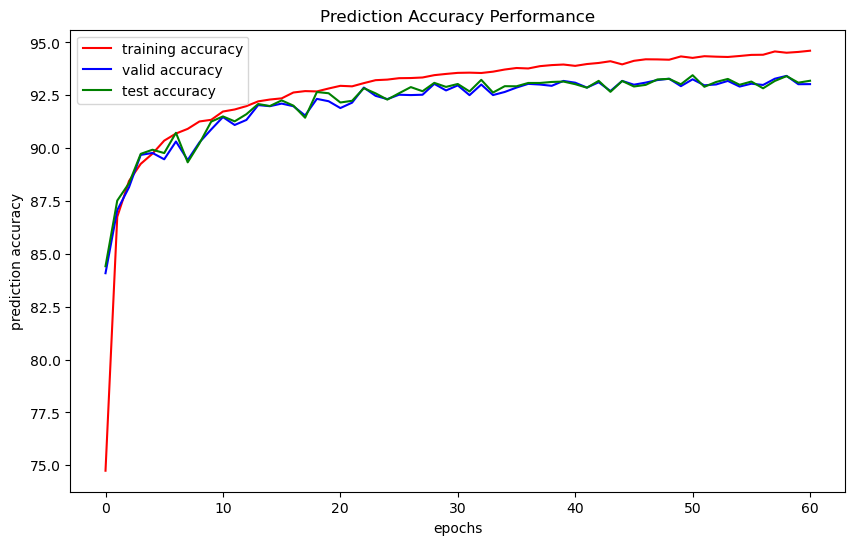

In [11]:
# display accuracy results
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

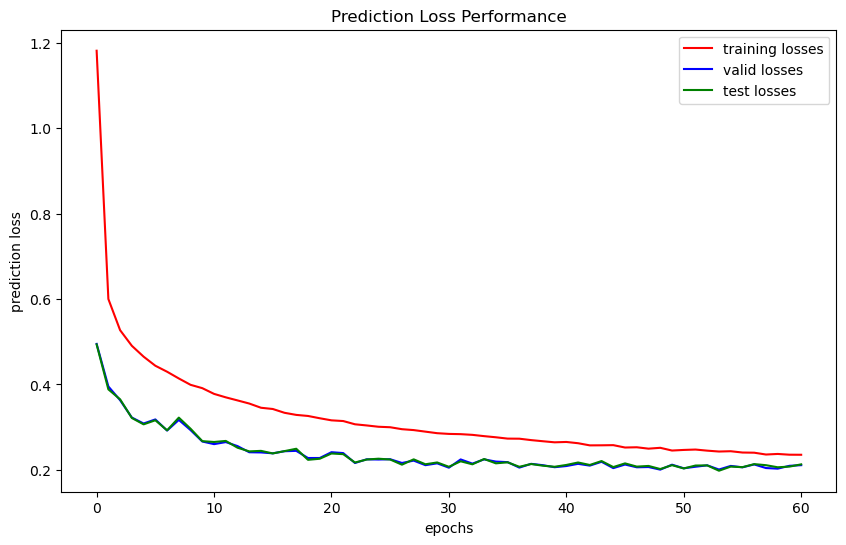

In [12]:
# display loss results
plot_loss_performance(train_losses, valid_losses, test_losses)